In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from protest_impact.util import cache, project_root

set_matplotlib_formats("svg")

In [2]:
from protest_impact.data.protests.sources.acled import load_acled

df = load_acled(file="acled-blm-2020-us.csv")

In [3]:
len(df["size"]), len(df["size"].dropna())

(7200, 4556)

In [4]:
df = df[
    (~df["size"].isna())
    & (~df["assoc_actor_1"].isna())
    & df["assoc_actor_1"].str.contains("Black Lives Matter")
]
print(df.shape)

(4198, 8)


In [5]:
df = df[df["location"].map(df["location"].value_counts()) >= 10]
df.shape, df["location"].nunique()

((548, 8), 44)

In [6]:
import os

import geocoder
from dotenv import load_dotenv

load_dotenv()


@cache
def get_population(city, region):
    g = geocoder.geonames(f"{city}, {region}", key=os.environ["GEONAMES_USERNAME"])
    return g.population


df["population"] = df.apply(
    lambda x: get_population(x["location"], x["admin1"]), axis=1
)
df = df[df["population"] > 0]

In [7]:
acled = df.copy()
df.head()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,weekday,size,population
2,2020-06-25,Peaceful protest,BLM: Black Lives Matter,California,Sacramento,"On 25 June 2020, dozens of people marched in p...",Thursday,50.0,490712.0
30,2020-06-25,Peaceful protest,BLM: Black Lives Matter; Labor Group (United S...,Massachusetts,Cambridge,"On 25 June 2020, several employees of the Whol...",Thursday,5.0,110402.0
31,2020-06-25,Peaceful protest,Occupy Movement; BLM: Black Lives Matter,New York,New York - Manhattan,"On 25 June 2020, hundreds of protesters staged...",Thursday,500.0,8804190.0
37,2020-06-25,Peaceful protest,BLM: Black Lives Matter,Georgia,Athens,"On 25 June 2020, hundreds of people attended a...",Thursday,500.0,127315.0
42,2020-06-25,Peaceful protest,BLM: Black Lives Matter,Missouri,Columbia,"On 25 June 2020, about 60 people protested in ...",Thursday,60.0,119108.0


<Axes: >

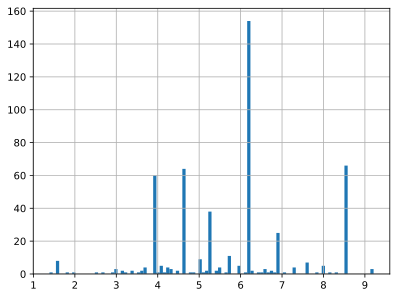

In [8]:
np.log(df["size"]).hist(bins=100)

<Axes: >

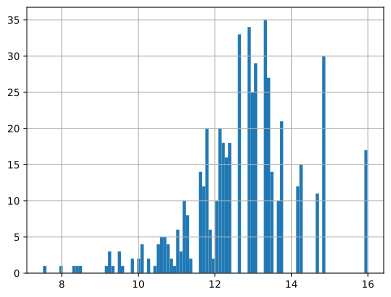

In [9]:
np.log(df["population"]).hist(bins=100)

## Monthly aggregate

In [10]:
# aggregate by location
df = (
    df.groupby(["location", "admin1"])
    .agg({"size": "sum", "population": "mean"})
    .reset_index()
)
df["log_size"] = np.log(df["size"])
df["log_population"] = np.log(df["population"])
df.head()

,location,admin1,size,population,log_size,log_population
0,Athens,Alabama,100.0,24966.0,4.605170,10.125270
1,Athens,Georgia,6050.0,127315.0,8.707814,11.754420
2,Athens,Ohio,220.0,25044.0,5.393628,10.128390
3,Athens,Tennessee,200.0,13688.0,5.298317,9.524275
4,Atlanta,Georgia,21077.0,463878.0,9.955938,13.047377


In [11]:
from protest_impact.data.weather import get_weather_history

weather_vars = [
    "tavg",
    "tmin",
    "tmax",
    "prcp",
    # "snow",
    "wdir",
    "wspd",
    # "wpgt",
    "pres",
    # "tsun",
]

for col in weather_vars:
    df[col] = df.apply(
        lambda x: get_weather_history(
            x["location"], country=x["admin1"] + ", " + "United States"
        )
        .loc["2020-05-25":"2020-06-25", col]
        .mean(),
        axis=1,
    )

In [12]:
df.head()

,location,admin1,size,population,log_size,log_population,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,Athens,Alabama,100.0,24966.0,4.605170,10.125270,23.550000,18.331250,29.046875,2.853125,144.234375,10.040625,1016.409375
1,Athens,Georgia,6050.0,127315.0,8.707814,11.754420,23.940625,19.031250,30.509375,2.618750,214.687500,7.337500,1017.678125
2,Athens,Ohio,220.0,25044.0,5.393628,10.128390,20.746875,15.128125,26.884375,11.353246,227.281250,5.785937,1016.803125
3,Athens,Tennessee,200.0,13688.0,5.298317,9.524275,22.770312,17.500000,28.515625,3.961875,171.668750,7.260625,1017.864375
4,Atlanta,Georgia,21077.0,463878.0,9.955938,13.047377,23.503125,18.821875,28.543750,3.871875,198.937500,7.534375,1016.843750


In [13]:
for col in weather_vars:
    X = df[[col, "log_population"]]
    X = (X - X.mean()) / X.std()
    # X = pd.concat([X, pd.get_dummies(df[["admin1"]])], axis=1)
    X = sm.add_constant(X)
    y = df["log_size"]
    y = (y - y.mean()) / y.std()
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"{col} {results.params[1]:.3f} p={results.pvalues[1]:.10f}")

tavg -0.002 p=0.9743116090
tmin -0.009 p=0.8976923052
tmax 0.025 p=0.7197282487
prcp -0.034 p=0.5995262576
wdir -0.001 p=0.9901576621
wspd 0.068 p=0.3175767040
pres -0.064 p=0.3473207238


Use only climate:

In [14]:
from protest_impact.data.weather import get_climate

weather_vars_ = ["tavg", "tmin", "tmax", "prcp", "wspd", "pres"]
for col in weather_vars_:
    df[col] = df.apply(
        lambda x: get_climate(
            x["location"],
            pd.to_datetime("2020-06-10"),
            country=x["admin1"] + ", " + "United States",
        )[col],
        axis=1,
    )
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [15]:
for col in weather_vars:
    X = df[[col, "log_population"]]
    X = (X - X.mean()) / X.std()
    X = pd.concat([X, pd.get_dummies(df[["admin1"]])], axis=1)
    X = sm.add_constant(X)
    y = df["log_size"]
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"{col} {results.params[1]:.3f} p={results.pvalues[1]:.6f}")

tavg 0.125 p=0.634900
tmin 0.158 p=0.561721
tmax 0.098 p=0.686031
prcp 0.243 p=0.126778
wdir -0.003 p=0.986247
wspd 0.171 p=0.438528
pres -0.112 p=0.727562


## Timeline for monthly

In [16]:
params = []
for month in tqdm(range(-24, 25)):
    month_start = pd.to_datetime("2020-05-25") + pd.DateOffset(months=month)
    month_end = pd.to_datetime("2020-06-25") + pd.DateOffset(months=month)
    for col in ["prcp"]:
        weather = df.apply(
            lambda x: get_weather_history(
                x["location"], country=x["admin1"] + ", " + "United States"
            )
            .loc[month_start:month_end, col]
            .mean(),
            axis=1,
        )
        weather.name = "weather"
        X = pd.concat([weather, df[["log_population"]]], axis=1)
        X = (X - X.mean()) / X.std()
        # X = pd.concat([X, pd.get_dummies(df_[["admin1", "location"]])], axis=1)
        X = sm.add_constant(X)
        y = df["log_size"]
        model = sm.OLS(y, X)
        results = model.fit()
        params.append(
            dict(
                month=month,
                col=col,
                beta=results.params["weather"],
                se=results.bse["weather"],
                p=results.pvalues["weather"],
                r2=results.rsquared,
            )
        )
params = pd.DataFrame(params)

  0%|          | 0/49 [00:00<?, ?it/s]

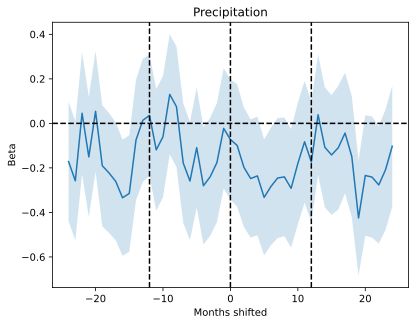

In [17]:
params_ = params.query("col in ['prcp']")
plt.plot(params_["month"], params_["beta"])
plt.fill_between(
    params_["month"],
    params_["beta"] - 1.96 * params_["se"],
    params_["beta"] + 1.96 * params_["se"],
    alpha=0.2,
)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(-12, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.axvline(12, color="black", linestyle="--")
plt.xlabel("Months shifted")
plt.ylabel("Beta")
plt.title("Precipitation")
plt.show()

## Timeline for climate

In [21]:
params = []
for month in tqdm(range(-24, 25)):
    month_start = pd.to_datetime("2020-05-25") + pd.DateOffset(months=month)
    month_end = pd.to_datetime("2020-06-25") + pd.DateOffset(months=month)
    for col in ["prcp"]:
        climate = df.apply(
            lambda x: get_climate(
                x["location"],
                pd.to_datetime(month_start + pd.DateOffset(days=15)),
                country=x["admin1"] + ", " + "United States",
            )[col],
            axis=1,
        )
        climate.name = "climate"
        X = pd.concat([climate, df[["log_population"]]], axis=1)
        X = (X - X.mean()) / X.std()
        # X = pd.concat([X, pd.get_dummies(df_[["admin1", "location"]])], axis=1)
        X = sm.add_constant(X)
        y = df["log_size"]
        model = sm.OLS(y, X)
        results = model.fit()
        params.append(
            dict(
                month=month,
                col=col,
                beta=results.params["climate"],
                se=results.bse["climate"],
                p=results.pvalues["climate"],
                r2=results.rsquared,
            )
        )
params = pd.DataFrame(params)

  0%|          | 0/49 [00:00<?, ?it/s]

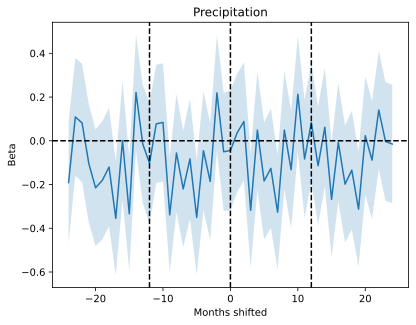

In [22]:
params_ = params.query("col in ['prcp']")
plt.plot(params_["month"], params_["beta"])
plt.fill_between(
    params_["month"],
    params_["beta"] - 1.96 * params_["se"],
    params_["beta"] + 1.96 * params_["se"],
    alpha=0.2,
)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(-12, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.axvline(12, color="black", linestyle="--")
plt.xlabel("Months shifted")
plt.ylabel("Beta")
plt.title("Precipitation")
plt.show()

## Timeline for monthly, non-climate component while controlling for climate

In [18]:
params = []
for month in tqdm(range(-24, 25)):
    month_start = pd.to_datetime("2020-05-25") + pd.DateOffset(months=month)
    month_end = pd.to_datetime("2020-06-25") + pd.DateOffset(months=month)
    for col in ["prcp"]:
        climate = df.apply(
            lambda x: get_climate(
                x["location"],
                pd.to_datetime(month_start + pd.DateOffset(days=15)),
                country=x["admin1"] + ", " + "United States",
            )[col],
            axis=1,
        )
        climate.name = "climate"
        weather = df.apply(
            lambda x: get_weather_history(
                x["location"], country=x["admin1"] + ", " + "United States"
            )
            .loc[month_start:month_end, col]
            .mean(),
            axis=1,
        )
        random_weather = weather - climate
        random_weather.name = "random_weather"
        X = pd.concat([random_weather, climate, df[["log_population"]]], axis=1)
        X = (X - X.mean()) / X.std()
        # X = pd.concat([X, pd.get_dummies(df_[["admin1", "location"]])], axis=1)
        X = sm.add_constant(X)
        y = df["log_size"]
        model = sm.OLS(y, X)
        results = model.fit()
        params.append(
            dict(
                month=month,
                col=col,
                beta=results.params["random_weather"],
                se=results.bse["random_weather"],
                p=results.pvalues["random_weather"],
                beta_control=results.params["climate"],
                se_control=results.bse["climate"],
                p_control=results.pvalues["climate"],
                r2=results.rsquared,
            )
        )
params = pd.DataFrame(params)

  0%|          | 0/49 [00:00<?, ?it/s]

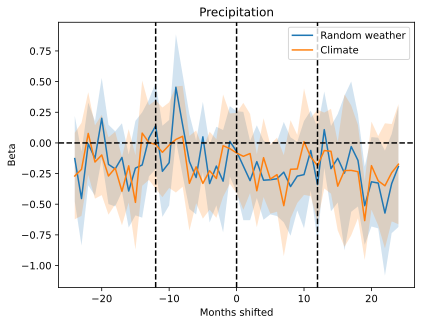

In [20]:
params_ = params.query("col in ['prcp']")
plt.plot(params_["month"], params_["beta"], label="Random weather")
plt.fill_between(
    params_["month"],
    params_["beta"] - 1.96 * params_["se"],
    params_["beta"] + 1.96 * params_["se"],
    alpha=0.2,
)
plt.plot(params_["month"], params_["beta_control"], label="Climate")
plt.fill_between(
    params_["month"],
    params_["beta_control"] - 1.96 * params_["se_control"],
    params_["beta_control"] + 1.96 * params_["se_control"],
    alpha=0.2,
)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(-12, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.axvline(12, color="black", linestyle="--")
plt.xlabel("Months shifted")
plt.ylabel("Beta")
plt.title("Precipitation")
plt.legend()
plt.show()

## Daily

In [113]:
df = acled.copy()
df["log_size"] = np.log(df["size"] + 1)
df["log_population"] = np.log(df["population"] + 1)
df.head()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,weekday,size,population,log_size,log_population
2,2020-06-25,Peaceful protest,BLM: Black Lives Matter,California,Sacramento,"On 25 June 2020, dozens of people marched in p...",Thursday,50.0,490712.0,3.931826,13.103615
30,2020-06-25,Peaceful protest,BLM: Black Lives Matter; Labor Group (United S...,Massachusetts,Cambridge,"On 25 June 2020, several employees of the Whol...",Thursday,5.0,110402.0,1.791759,11.611893
31,2020-06-25,Peaceful protest,Occupy Movement; BLM: Black Lives Matter,New York,New York - Manhattan,"On 25 June 2020, hundreds of protesters staged...",Thursday,500.0,8804190.0,6.216606,15.990738
37,2020-06-25,Peaceful protest,BLM: Black Lives Matter,Georgia,Athens,"On 25 June 2020, hundreds of people attended a...",Thursday,500.0,127315.0,6.216606,11.754427
42,2020-06-25,Peaceful protest,BLM: Black Lives Matter,Missouri,Columbia,"On 25 June 2020, about 60 people protested in ...",Thursday,60.0,119108.0,4.110874,11.687794


In [128]:
from protest_impact.data.weather import get_weather

for col in weather_vars:
    df[col] = df.apply(
        lambda x: get_weather(
            x["location"], x["event_date"], country=x["admin1"] + ", United States"
        )[col],
        axis=1,
    )

In [129]:
for col in weather_vars:
    X = df[[col, "log_population"]]
    X = (X - X.mean()) / X.std()
    X = pd.concat([X, pd.get_dummies(df[["admin1", "location"]])], axis=1)
    # X = pd.concat([X, pd.get_dummies(df[["admin1"]])], axis=1)
    X = sm.add_constant(X)
    y = df["log_size"]
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"{col} {results.params[1]:.3f} p={results.pvalues[1]:.6f}")
print()

tavg -0.071 p=0.496469
tmin 0.007 p=0.950416
tmax -0.079 p=0.402781
prcp -0.046 p=0.509238
wdir 0.061 p=0.402422
wspd 0.041 p=0.606481
pres 0.065 p=0.379777



In [130]:
# add mean size per location
df["mean_size_by_location"] = df.groupby(["location", "admin1"])["size"].transform(
    "mean"
)
df["log_mean_size_by_location"] = np.log(
    df.groupby(["location", "admin1"])["size"].transform("mean") + 1
)

In [131]:
for col in weather_vars:
    X = df[[col, "log_population", "log_mean_size_by_location"]]
    # X = pd.concat([X, pd.get_dummies(df[["admin1", "location"]])], axis=1)
    # X = pd.concat([X, pd.get_dummies(df[["admin1"]])], axis=1)
    X = sm.add_constant(X)
    y = df["log_size"]
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"{col} {results.params[1]:.3f} p={results.pvalues[1]:.6f}")

tavg -0.017 p=0.217835
tmin -0.010 p=0.437797
tmax -0.017 p=0.162460
prcp -0.004 p=0.505601
wdir 0.001 p=0.322096
wspd 0.003 p=0.832149
pres 0.014 p=0.213946


In [134]:
for col in weather_vars:
    climate = df.apply(
        lambda x: get_climate(
            x["location"],
            pd.to_datetime(x["event_date"]),
            country=x["admin1"] + ", " + "United States",
        )[col],
        axis=1,
    )
    weather = df.apply(
        lambda x: get_weather(
            x["location"], x["event_date"], country=x["admin1"] + ", United States"
        )[col],
        axis=1,
    )
    X = pd.concat([weather, climate, df[["log_population"]]], axis=1)
    X = (X - X.mean()) / X.std()
    # X = pd.concat([X, pd.get_dummies(df[["admin1", "location"]])], axis=1)
    X = sm.add_constant(X)
    y = df["log_size"]
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"{col} {results.params[1]:.3f} p={results.pvalues[1]:.6f}")

tavg -0.292 p=0.001607
tmin -0.375 p=0.000061
tmax -0.252 p=0.003151
prcp -0.052 p=0.459078
wdir 0.081 p=0.247729
wspd 0.053 p=0.503602
pres -0.141 p=0.071064


## Timeline for daily

In [137]:
from dateutil.relativedelta import relativedelta

params = []
for day in tqdm(range(-14, 15)):
    for col in weather_vars:
        df[col] = df.apply(
            lambda x: get_weather(
                x["location"],
                x["event_date"] + pd.Timedelta(days=day),
                country=x["admin1"] + ", United States",
            )[col],
            axis=1,
        )
        X = df[[col, "log_population", "log_mean_size_by_location"]]
        X = (X - X.mean()) / X.std()
        X = pd.concat([X, pd.get_dummies(df[["admin1", "location"]])], axis=1)
        X = sm.add_constant(X)
        y = df["log_size"]
        model = sm.OLS(y, X)
        results = model.fit()
        params.append(
            dict(
                day=day,
                col=col,
                beta=results.params[1],
                se=results.bse[1],
                p=results.pvalues[1],
                r2=results.rsquared,
            )
        )
params = pd.DataFrame(params)

  0%|          | 0/29 [00:00<?, ?it/s]

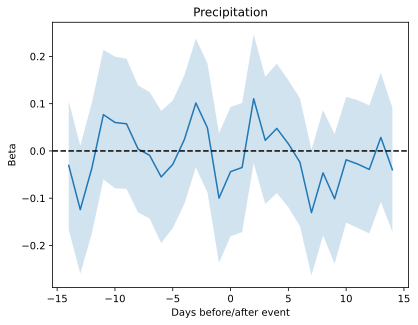

In [138]:
params_ = params.query("col in ['prcp']")
plt.plot(params_["day"], params_["beta"])
plt.fill_between(
    params_["day"],
    params_["beta"] - 1.96 * params_["se"],
    params_["beta"] + 1.96 * params_["se"],
    alpha=0.2,
)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Days before/after event")
plt.ylabel("Beta")
plt.title("Precipitation")
plt.show()

## Again but with non-climate weather

In [147]:
results.params

const                        5.789380
0                           -0.064777
1                           -0.178658
log_population               0.008783
log_mean_size_by_location    0.746293
dtype: float64

In [ ]:
params = []
for day in tqdm(range(-14, 15)):
    for col in ["prcp"]:
        climate = df.apply(
            lambda x: get_climate(
                x["location"],
                pd.to_datetime(x["event_date"]) + pd.Timedelta(days=day),
                country=x["admin1"] + ", " + "United States",
            )[col],
            axis=1,
        )
        climate.name = "climate"
        weather = df.apply(
            lambda x: get_weather(
                x["location"], x["event_date"], country=x["admin1"] + ", United States"
            )[col],
            axis=1,
        )
        random_weather = weather - climate
        random_weather.name = "random_weather"
        X = pd.concat(
            [
                random_weather,
                climate,
                df[["log_population", "log_mean_size_by_location"]],
            ],
            axis=1,
        )
        X = (X - X.mean()) / X.std()
        # X = pd.concat([X, pd.get_dummies(df_[["admin1", "location"]])], axis=1)
        X = sm.add_constant(X)
        y = df["log_size"]
        model = sm.OLS(y, X)
        results = model.fit()
        params.append(
            dict(
                day=day,
                col=col,
                beta=results.params["random_weather"],
                se=results.bse["random_weather"],
                p=results.pvalues["random_weather"],
                beta_control=results.params["climate"],
                se_control=results.bse["climate"],
                p_control=results.pvalues["climate"],
                r2=results.rsquared,
            )
        )
params = pd.DataFrame(params)

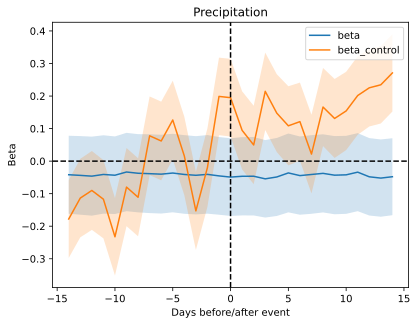

In [152]:
params_ = params.query("col in ['prcp']")
plt.plot(params_["day"], params_["beta"], label="beta")
plt.fill_between(
    params_["day"],
    params_["beta"] - 1.96 * params_["se"],
    params_["beta"] + 1.96 * params_["se"],
    alpha=0.2,
)
plt.plot(params_["day"], params_["beta_control"], label="beta_control")
plt.fill_between(
    params_["day"],
    params_["beta_control"] - 1.96 * params_["se_control"],
    params_["beta_control"] + 1.96 * params_["se_control"],
    alpha=0.2,
)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Days before/after event")
plt.ylabel("Beta")
plt.title("Precipitation")
plt.legend()
plt.show()